# Sugar EDA

Within the US, sugar is produced in the following places.

Sugarcane 
* Florida: The largest sugarcane-producing region in the US, with most production in Palm Beach County
* Louisiana: A major producer of sugarcane
* Texas
* Hawaii

Sugar beets 
* California
* Colorado
* Idaho
* Michigan
* Minnesot
* Montana
* Nebraska
* North Dakota
* Oregon
* Washington
* Wyoming

Other uses of sugar outside of food and beverages.

* Pharmaceuticals: Sugar can be used to improve the taste of medications and act as a binder for pill coatings. 
* Wastewater treatment: Liquid sugar can be added to wastewater to aid in the de-nitrification process. 
* Agriculture: Sugar solutions can be used as a fertilizer in vineyards to stimulate microbial activity. 
* Cleaning: Sugar can be used to clean certain stains on clothing or appliances. 
* Bioplastics: Sugar can be used as a base material for producing bioplastics.

Historically, sugar production contributed to the growth of slavery in Louisiana and the U.S. annexation of Hawaii.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import seaborn as sns
import statsmodels.api as sm
import time

In [2]:
df = pd.read_csv('../sugar_data/combined_sugar_data.csv')
df = df.drop(columns=['expiry']) # we have the days to expiry already (DTE)
df['Date'] = pd.to_datetime(df['Date'])       # ensure it's datetime
df.set_index('Date', inplace=True)            # set it as the index


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5079 entries, 2005-01-03 to 2025-03-18
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     5079 non-null   float64
 1   High                     5079 non-null   float64
 2   Low                      5079 non-null   float64
 3   Close                    5079 non-null   float64
 4   Volume                   5079 non-null   int64  
 5   Dividends                5079 non-null   float64
 6   Stock Splits             5079 non-null   float64
 7   Year                     5079 non-null   int64  
 8   Month                    5079 non-null   int64  
 9   Day                      5079 non-null   int64  
 10  Day_Of_Year              5079 non-null   int64  
 11  DTE                      5079 non-null   int64  
 12  Log_Return               5079 non-null   float64
 13  7D_Volatility            5079 non-null   float64
 14  14D_Vo

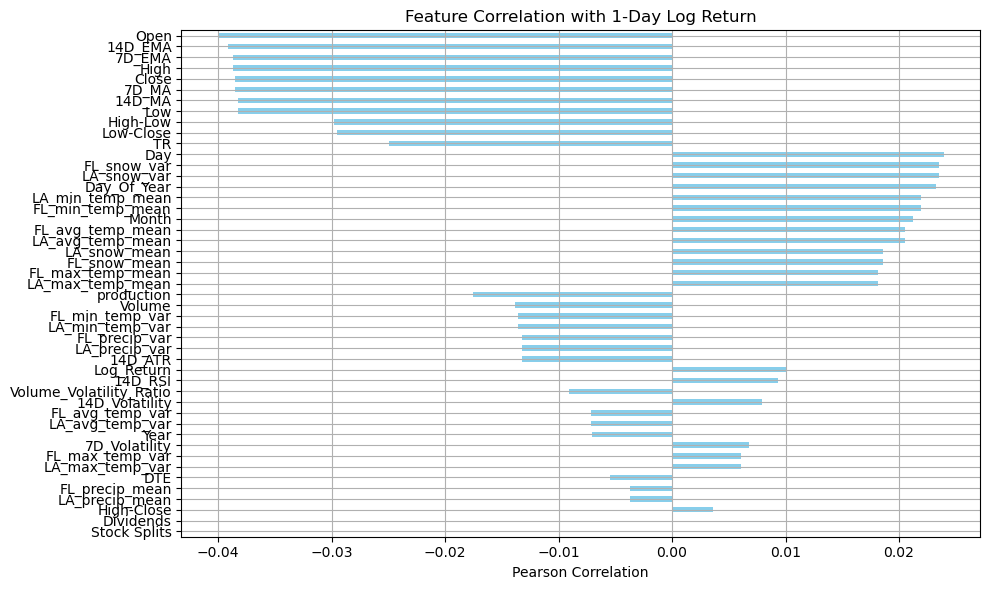

In [4]:
# Compute correlation with target
correlations = df.corr()['shift_Log_Return'].drop('shift_Log_Return').sort_values(key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Feature Correlation with 1-Day Log Return')
plt.xlabel('Pearson Correlation')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Above is the full data (finance, weather, and production). In the rest of this notebook, we mostly just explore the financial data since the goal of our project is to first develop a baseline model before bringing in exogenous factors like weather data and USDA reports on production.

In [5]:
df_sugar = pd.read_csv('sugar_prices.csv')
df_sugar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6097 non-null   object 
 1   open    6097 non-null   float64
 2   high    6097 non-null   float64
 3   low     6097 non-null   float64
 4   close   6097 non-null   float64
 5   volume  6097 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 285.9+ KB


In [6]:
# make date: str -> datetime; when plotting, the date will be used as the x-axis

df_sugar['date'] = pd.to_datetime(df_sugar['date'])  # Convert string to datetime

# Set the date column as the index
df_sugar.set_index('date', inplace=True)

In [7]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, metric, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i][metric]))
    sigmas = np.insert(sigmas, 0, np.full((n), 0)) # makes the array length n, the lengthening uses 0's
    return sigmas


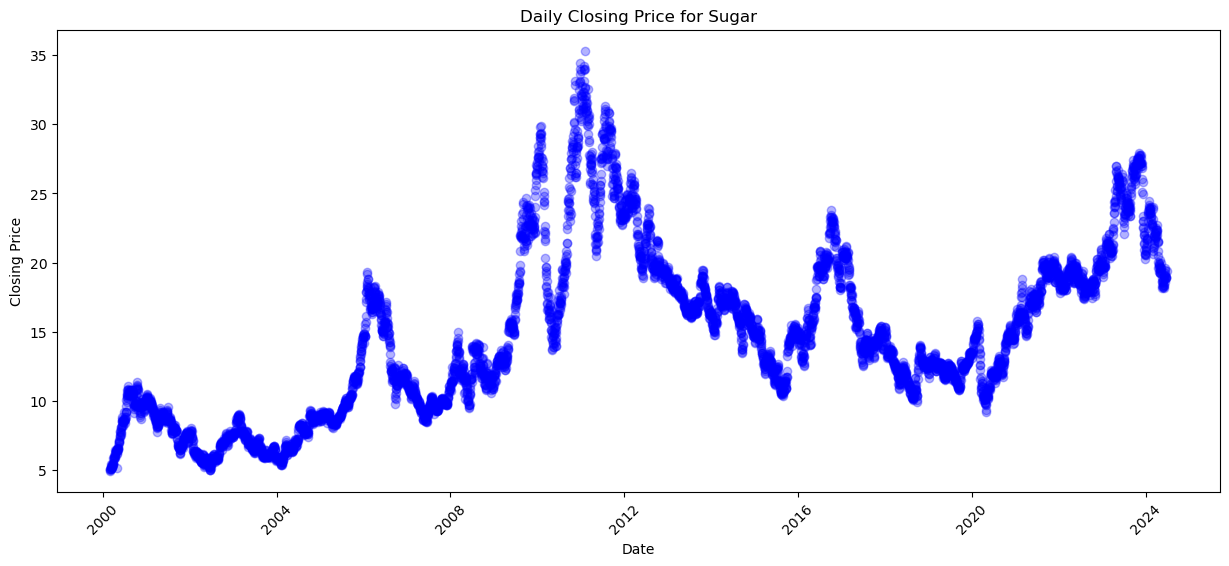

In [8]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, df_sugar['close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Sugar')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [9]:
rolling_sigmas_sugar = volatilities(df_sugar,'close',n=30)

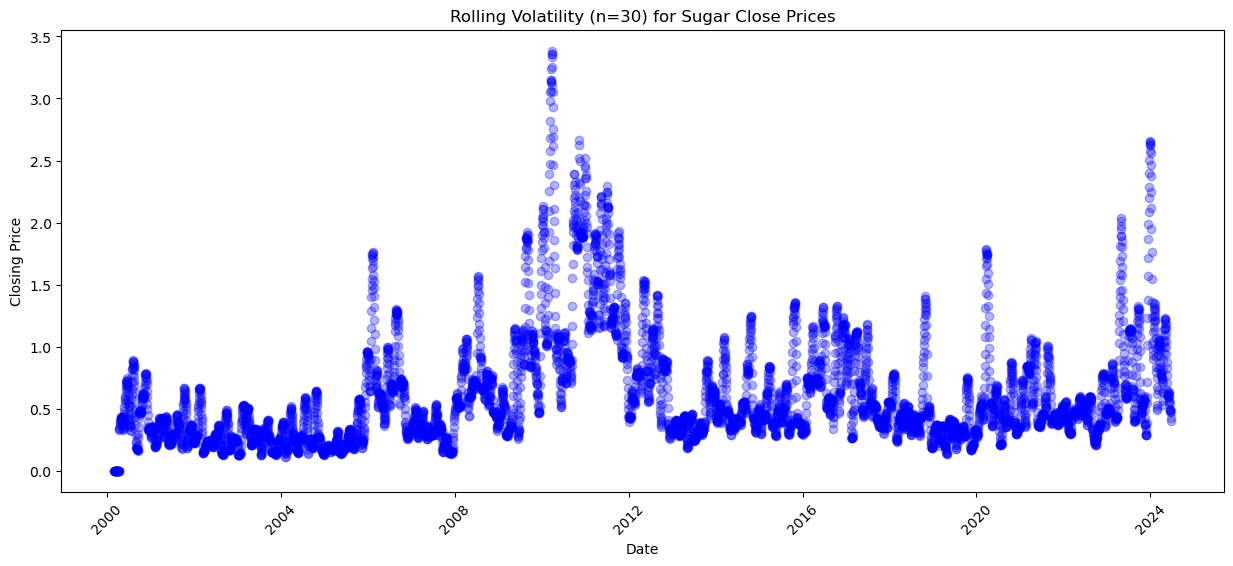

In [10]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, rolling_sigmas_sugar, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

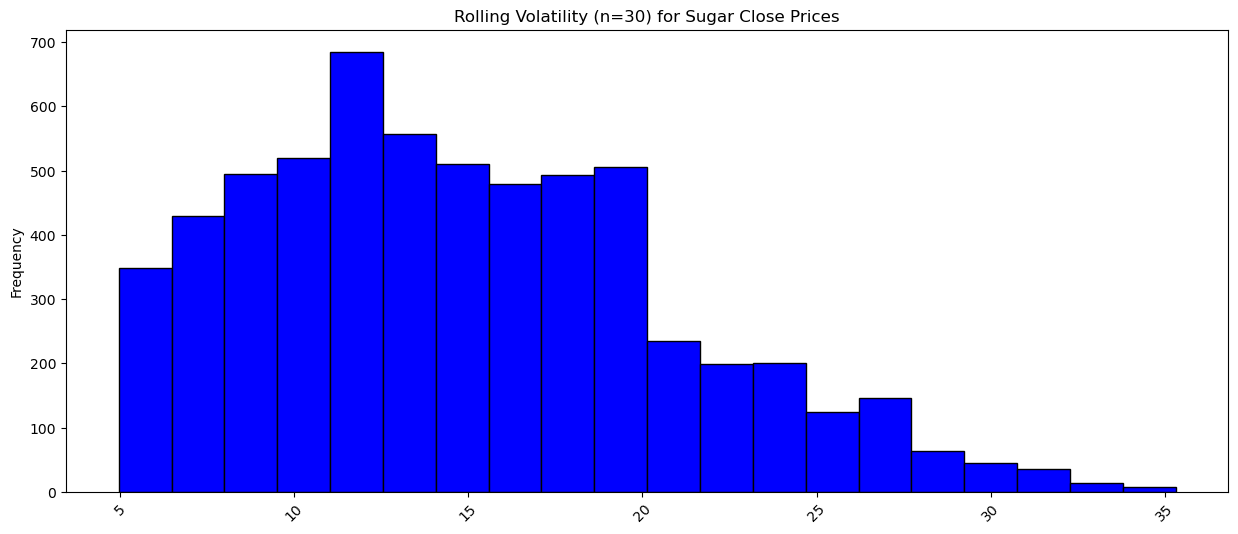

In [11]:
# histogram
plt.figure(figsize=(15, 6))
plt.hist(df_sugar['close'], bins=20, edgecolor='black',color = 'b')
plt.ylabel('Frequency')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

### (Partial) Autocorrelation

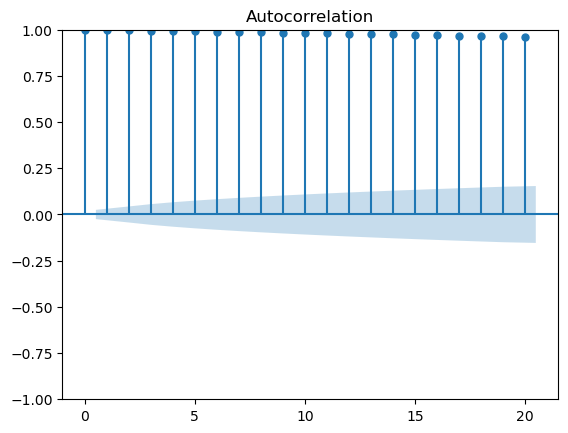

In [12]:
sm.graphics.tsa.plot_acf(df_sugar['close'], lags = 20) # correlation between X and a delayed copy of itself, up to 20 lags
plt.show()

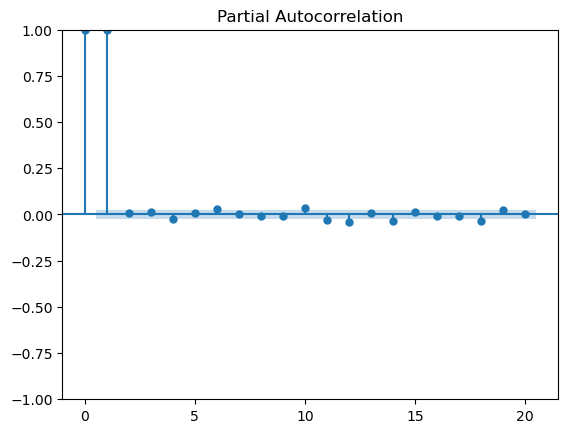

In [13]:
# Partial autocorrelation is a statistical measure in time series analysis that represents the correlation between an observation 
# and its lagged values, while accounting for the influence of all the intervening lags, essentially isolating the direct 
# relationship between two points in time without the effect of other intermediary observations

sm.graphics.tsa.plot_pacf(df_sugar['close'], lags = 20)
plt.show()

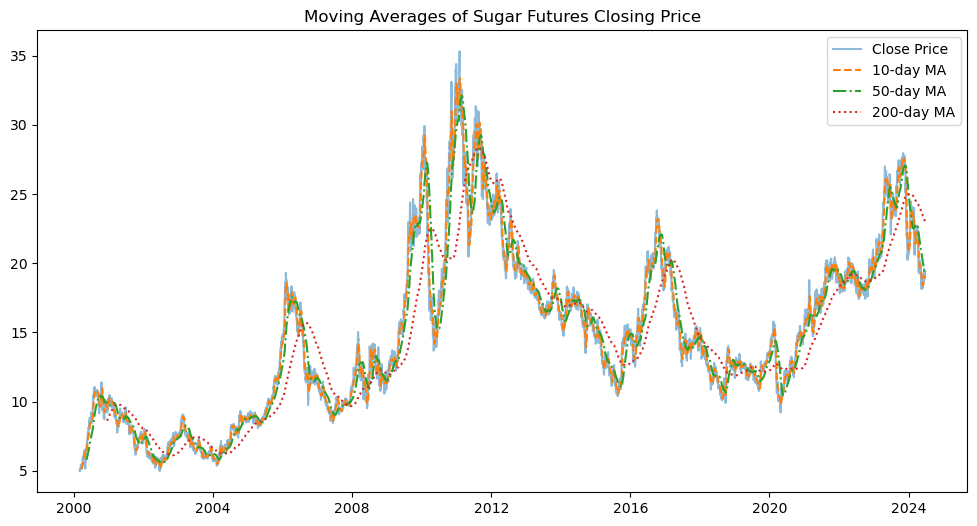

In [14]:
# Moving Averages
df_sugar["MA_10"] = df_sugar["close"].rolling(window=10).mean()
df_sugar["MA_50"] = df_sugar["close"].rolling(window=50).mean()
df_sugar["MA_200"] = df_sugar["close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_sugar["close"], label="Close Price", alpha=0.5)
plt.plot(df_sugar["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_sugar["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_sugar["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Sugar Futures Closing Price")
plt.show()

### Seasonality and Periodicity

In [15]:
# for seasonal decomposition
from statsmodels.tsa.seasonal import STL

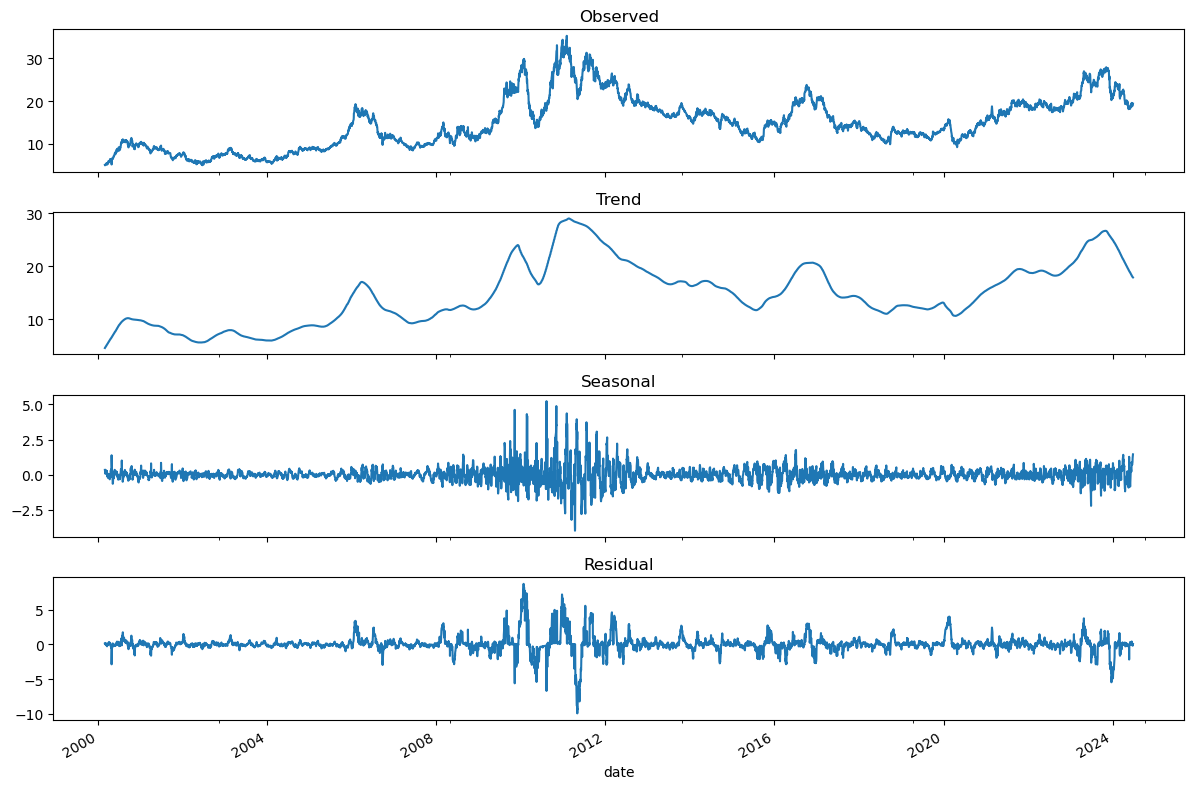

In [16]:
# Seasonal Decomposition (Using STL)
stl = STL(df_sugar["close"], period=60,robust=True)  # 5 day period (since weekends are excluded)
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [18]:
split_index = int(len(df_sugar)*0.8)
df_train = df_sugar[:split_index]['close']
df_test = df_sugar[split_index:]['close']

In [19]:
len(df_train)+len(df_test)==len(df_sugar)

True

In [20]:
# Perform ADF test to check for stationarity
result = adfuller(df_sugar['close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -2.5858266512872596
p-value: 0.09596213580817758


### Trying out SARIMA

In [21]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usi

                                      SARIMAX Results                                       
Dep. Variable:                                close   No. Observations:                 4877
Model:             SARIMAX(30, 1, 1)x(0, 1, [], 12)   Log Likelihood               -2407.358
Date:                              Sat, 19 Apr 2025   AIC                           4878.715
Time:                                      11:46:33   BIC                           5086.383
Sample:                                           0   HQIC                          4951.601
                                             - 4877                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054     11.736      0.000      1.000     -22.998      23.008
ar.L2          0.00

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


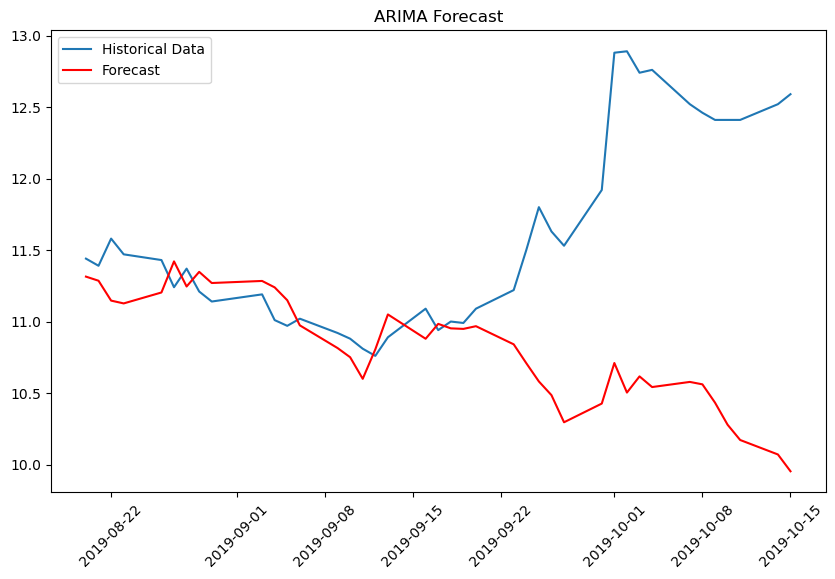

In [22]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = 40 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score

days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviaiton of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print()

Days = 5
Standard deviaiton of test data: 0.0719026003718356
Root MSE: 0.27714285349442425
R^2 score: -17.57069628527385

Days = 10
Standard deviaiton of test data: 0.14338760803331566
Root MSE: 0.21834816256607173
R^2 score: -1.5765189074738881

Days = 15
Standard deviaiton of test data: 0.22294984511973653
Root MSE: 0.19855283796740386
R^2 score: 0.1502306331287151

Days = 20
Standard deviaiton of test data: 0.24535412187285377
Root MSE: 0.18834328435012687
R^2 score: 0.37971688846797913

Days = 25
Standard deviaiton of test data: 0.2349112718561194
Root MSE: 0.24480883304555387
R^2 score: -0.13129331787493426

Days = 30
Standard deviaiton of test data: 0.4244765287040269
Root MSE: 0.652121514703685
R^2 score: -1.4415912053493458



Rule 11.06. Last Trading Day
(a) The Last Trading Day for each delivery month in the Sugar No. 11 Contract shall be the last full
trading day of the month preceding the delivery month.

Unless the Board directs otherwise, trading shall be limited to sugar deliverable in the delivery
months of January, March, May, July, and October

[See here](https://www.ice.com/publicdocs/rulebooks/futures_us/11_Sugar_11.pdf) and [here](https://www.ice.com/products/23/Sugar-No-11-Futures) for info on Sugar No. 11 futures trading. The Sugar No. 11 contract is the world benchmark contract for raw sugar trading. The contract prices the physical delivery of raw cane sugar, free-on-board the receiver's vessel to a port within the country of origin of the sugar.

# Utility functions for getting more (derived) features

`'SB=F'` is Sugar No. 11 which is an index for the US but also other countries.
`'SF=F'` is Sugar No. 16 which is an index also for the US and some other countries.

In [24]:
sugar_futures = yf.Ticker('SB=F')
df_sugar_futures = sugar_futures.history(period='max')
df_sugar_futures
#pd.read_csv('sugar_prices2.csv')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-03-01 00:00:00-05:00,4.980000,5.140000,4.980000,5.080000,10467,0.0,0.0
2000-03-02 00:00:00-05:00,5.080000,5.130000,4.940000,4.960000,9638,0.0,0.0
2000-03-03 00:00:00-05:00,4.960000,5.060000,4.960000,5.050000,5879,0.0,0.0
2000-03-06 00:00:00-05:00,5.100000,5.160000,5.030000,5.040000,11290,0.0,0.0
2000-03-07 00:00:00-05:00,5.050000,5.140000,5.030000,5.070000,9369,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-11 00:00:00-04:00,18.100000,18.309999,17.910000,18.000000,78004,0.0,0.0
2025-04-14 00:00:00-04:00,17.980000,18.120001,17.809999,17.870001,52942,0.0,0.0
2025-04-15 00:00:00-04:00,17.860001,17.950001,17.510000,17.520000,68076,0.0,0.0


In [25]:
from pandas.tseries.offsets import BDay, MonthEnd

In [26]:
# This is for Sugar No. 16 contracts
"""ALLOWED_DELIVERY_MONTHS = [1, 3, 5, 7, 9, 11] # for sugar no. 16
# sugar no. 16: Last Trading day: Eighth calendar day of the month preceding the delivery month

import pandas as pd

def get_expiry(dt):
    """
    #Given a timestamp dt, returns the expiry date as the 8th calendar day 
    #of the month preceding the next allowed delivery month.
    #This version checks both the current and next year to ensure the expiry is in the future.
    """
    dt = pd.Timestamp(dt)
    # Loop over the current year and the next year
    for year in [dt.year, dt.year + 1]:
        for m in sorted(ALLOWED_DELIVERY_MONTHS):
            # Compute the expiry date for delivery month m in the given year.
            # The expiry is the 8th day of the month preceding the delivery month.
            if m == 1:
                # If the delivery month is January, expiry is December 8 of the previous year.
                expiry_year = year - 1
                expiry_month = 12
            else:
                expiry_year = year
                expiry_month = m - 1
            try:
                expiry = pd.Timestamp(year=expiry_year, month=expiry_month, day=8)
            except ValueError:
                # In case the day is invalid (should not occur for day=8)
                continue
            # Return the first expiry that is after the input date.
            if expiry > dt:
                return expiry
    # If none found, return None (or raise an exception)
    return None
"""

IndentationError: unexpected indent (2477552007.py, line 12)

In [27]:
ALLOWED_DELIVERY_MONTHS = [1, 3, 5, 7, 10] # for sugar no. 11

def get_expiry(dt): # this is for sugar no. 11
    """
    Given a timestamp dt, returns the expiry date as the last trading day of the month
    preceding the next allowed delivery month.
    """
    dt = pd.Timestamp(dt)
    # Loop through allowed delivery months (sorted in ascending order)
    for m in sorted(ALLOWED_DELIVERY_MONTHS):
        # For the current year, build the delivery date as the first day of month m
        delivery_date = pd.Timestamp(year=dt.year, month=m, day=1)
        # Expiry is defined as the last day of the month preceding the delivery month
        expiry = delivery_date + MonthEnd(-1)
        # Adjust expiry to the last business day if it falls on a weekend
        if expiry.weekday() >= 5:  # Saturday=5, Sunday=6
            expiry -= BDay(1)
        # Check if this expiry is still in the future relative to dt
        if expiry > dt:
            return expiry

    # If no delivery month in the current year qualifies, use the first allowed month of next year
    m = sorted(ALLOWED_DELIVERY_MONTHS)[0]
    delivery_date = pd.Timestamp(year=dt.year+1, month=m, day=1)
    expiry = delivery_date + MonthEnd(-1)
    if expiry.weekday() >= 5:
        expiry -= BDay(1)
    return expiry

In [28]:
def extend_market_data(df):
    """
    :param df: The pandas dataframe obtained from yfinance library
    :return: The extended market data
    """
    ########################################################
    # Seasonality & Time Features
    # remove time zone featuress
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Day_Of_Year'] = df.index.dayofyear
    # get the expiry date of this specific contract
    
    # df["expiry"] = df.index.map(lambda x: expiry_series[expiry_series >= x].iloc[0])

    df['expiry'] = df.index.to_series().apply(get_expiry)
    # df['expiry'] = df['datetime'].apply(get_expiry)
   
    # computing the days to expiry
    df["DTE"] = (df["expiry"] - df.index).dt.days

    ##############################################################
    # Volatility Features:
    # Historical Volatility
    df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
    df['7D_Volatility'] = df['Log_Return'].rolling(window=7).std()
    df['14D_Volatility'] = df['Log_Return'].rolling(window=14).std()
    # Average True Range (ATR)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['14D_ATR'] = df['TR'].rolling(window=14).mean()
    # Volume-to-Volatility Ratio
    df['Volume_Volatility_Ratio'] = df['Volume'] / df['14D_Volatility']

    ##############################################################
    # Momentum Indicator Features:
    # Relative Strength Index (RSI)
    # Measures the speed and change of price movements.
    # Values above 70 indicate overbought conditions, below 30 indicate oversold conditions.
    delta =df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df[f'14D_RSI'] = 100 - (100 / (1 + rs))

    ###############################################################
    # Trend Indicator Features:
    # Moving Average
    df['7D_MA'] = df['Close'].rolling(window=7).mean()
    df['14D_MA'] = df['Close'].rolling(window=14).mean()
    # Exponential Moving Average (EMA)
    # A weighted version of moving average giving more weight to recent prices.
    df['7D_EMA'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['14D_EMA'] = df['Close'].ewm(span=14, adjust=False).mean()

    return df

In [29]:
df = extend_market_data(df_sugar_futures)
df['expiry']

Date
2000-03-01   2000-04-28
2000-03-02   2000-04-28
2000-03-03   2000-04-28
2000-03-06   2000-04-28
2000-03-07   2000-04-28
                ...    
2025-04-11   2025-04-30
2025-04-14   2025-04-30
2025-04-15   2025-04-30
2025-04-16   2025-04-30
2025-04-17   2025-04-30
Name: expiry, Length: 6303, dtype: datetime64[ns]

In [30]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Day,...,High-Close,Low-Close,TR,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,7D_EMA,14D_EMA
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,4.980000,5.140000,4.980000,5.080000,10467,0.0,0.0,2000,3,1,...,NaN,NaN,0.160000,NaN,NaN,NaN,NaN,NaN,5.080000,5.080000
2000-03-02,5.080000,5.130000,4.940000,4.960000,9638,0.0,0.0,2000,3,2,...,0.050000,0.140000,0.190000,NaN,NaN,NaN,NaN,NaN,5.050000,5.064000
2000-03-03,4.960000,5.060000,4.960000,5.050000,5879,0.0,0.0,2000,3,3,...,0.100000,0.000000,0.100000,NaN,NaN,NaN,NaN,NaN,5.050000,5.062133
2000-03-06,5.100000,5.160000,5.030000,5.040000,11290,0.0,0.0,2000,3,6,...,0.110000,0.020000,0.130000,NaN,NaN,NaN,NaN,NaN,5.047500,5.059182
2000-03-07,5.050000,5.140000,5.030000,5.070000,9369,0.0,0.0,2000,3,7,...,0.100000,0.010000,0.110000,NaN,NaN,NaN,NaN,NaN,5.053125,5.060625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11,18.100000,18.309999,17.910000,18.000000,78004,0.0,0.0,2025,4,11,...,0.189999,0.210001,0.400000,0.480714,5.192777e+06,32.692311,18.424286,18.834286,18.370697,18.688488
2025-04-14,17.980000,18.120001,17.809999,17.870001,52942,0.0,0.0,2025,4,14,...,0.120001,0.190001,0.310001,0.474286,3.746480e+06,26.704557,18.247143,18.717143,18.245523,18.579356
2025-04-15,17.860001,17.950001,17.510000,17.520000,68076,0.0,0.0,2025,4,15,...,0.080000,0.360001,0.440001,0.476428,4.667811e+06,25.336935,18.058572,18.586429,18.064142,18.438109


In [31]:
df.to_csv('sugar_data/finance_data.csv',index=True)

OSError: Cannot save file into a non-existent directory: 'sugar_data'

# Features

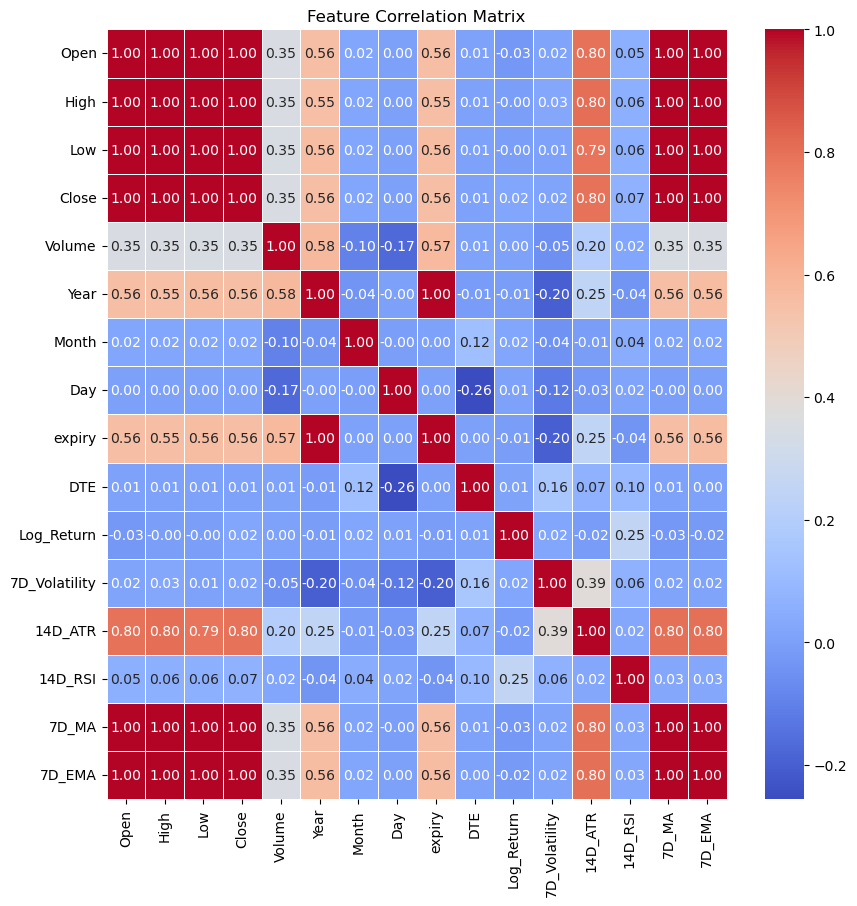

In [32]:
all_features = ['Open', 'High', 'Low', 'Close', 'Volume',
       'Year', 'Month', 'Day', 'expiry', 'DTE', 'Log_Return',
       '7D_Volatility', '14D_ATR', '14D_RSI',
       '7D_MA', '7D_EMA']

correlation_matrix = df[all_features].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Volume Analysis

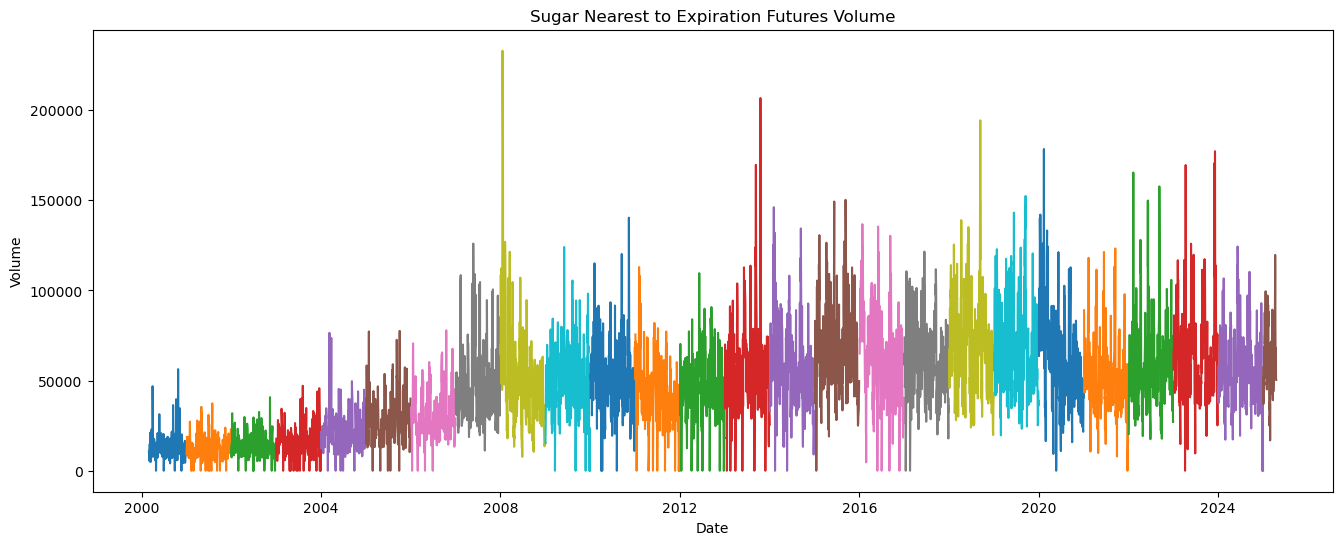

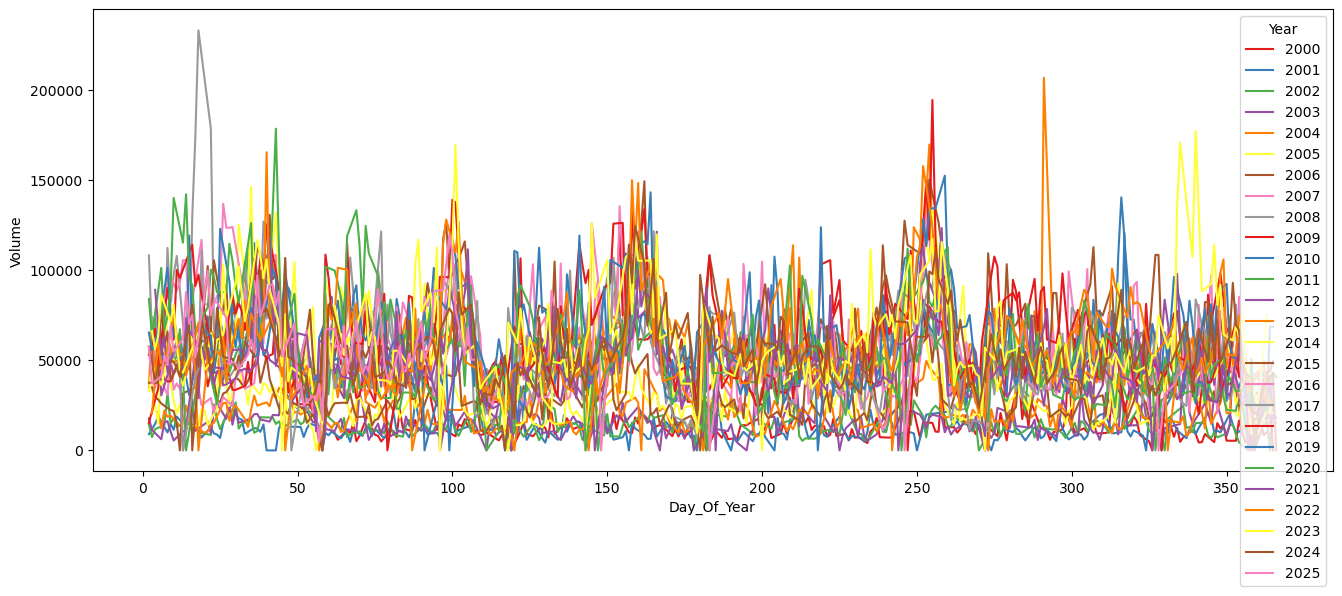

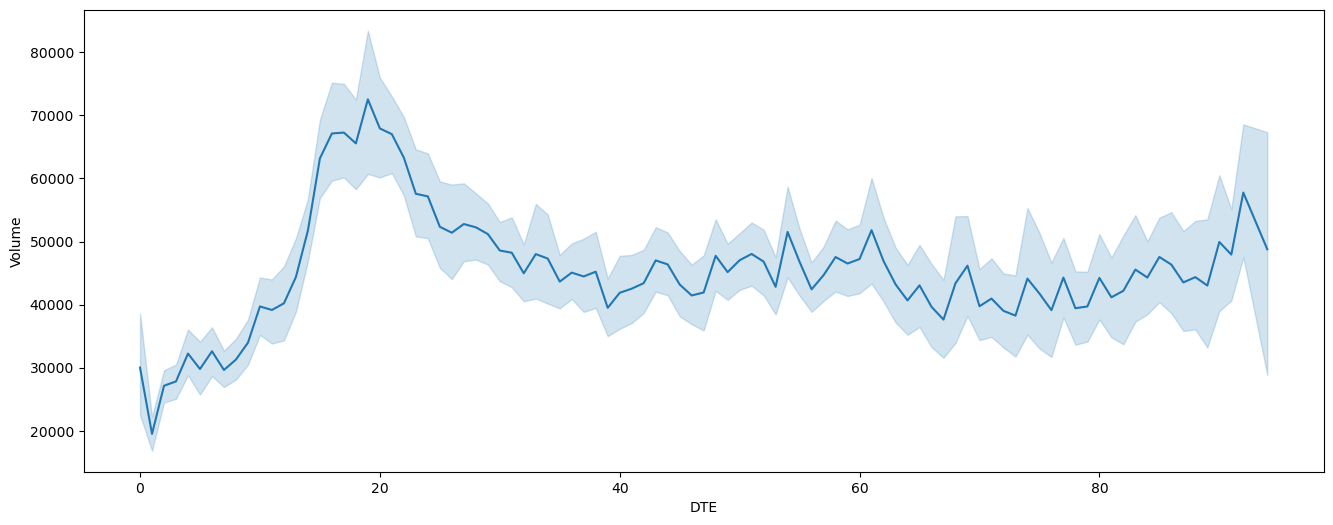

In [33]:
plt.figure(figsize = (16,6))
plt.title("Sugar Nearest to Expiration Futures Volume")
for year in df['Year'].unique():  # Loop through each unique year
    yearly_data = df[df['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = df, hue ='Year', palette='Set1')
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'DTE', y = 'Volume', data = df)
plt.show()

# Price Analysis

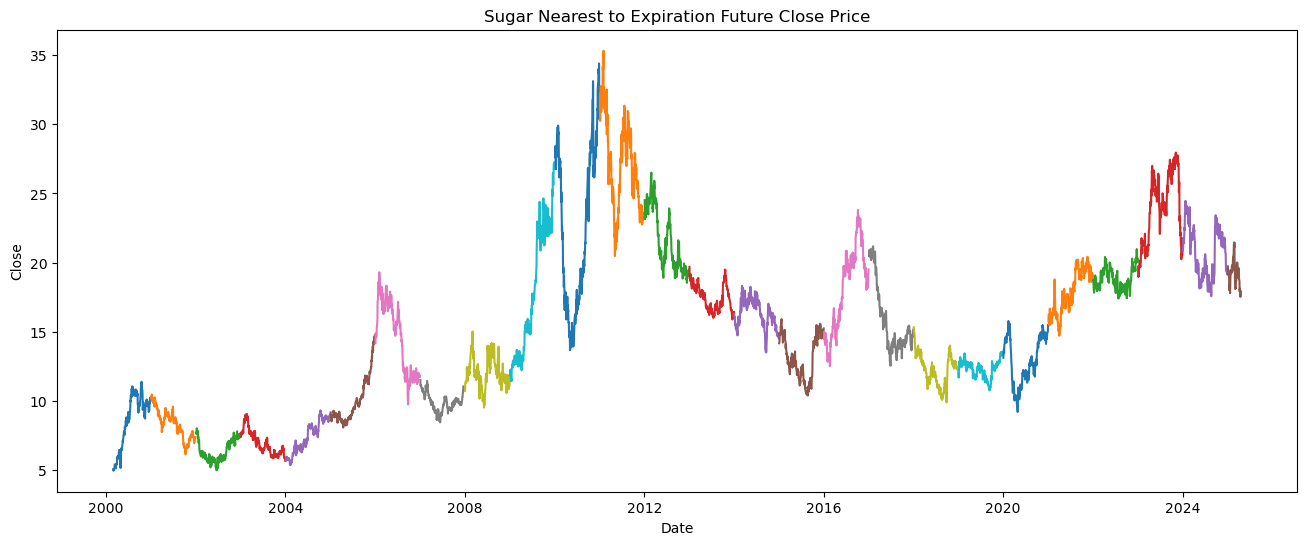

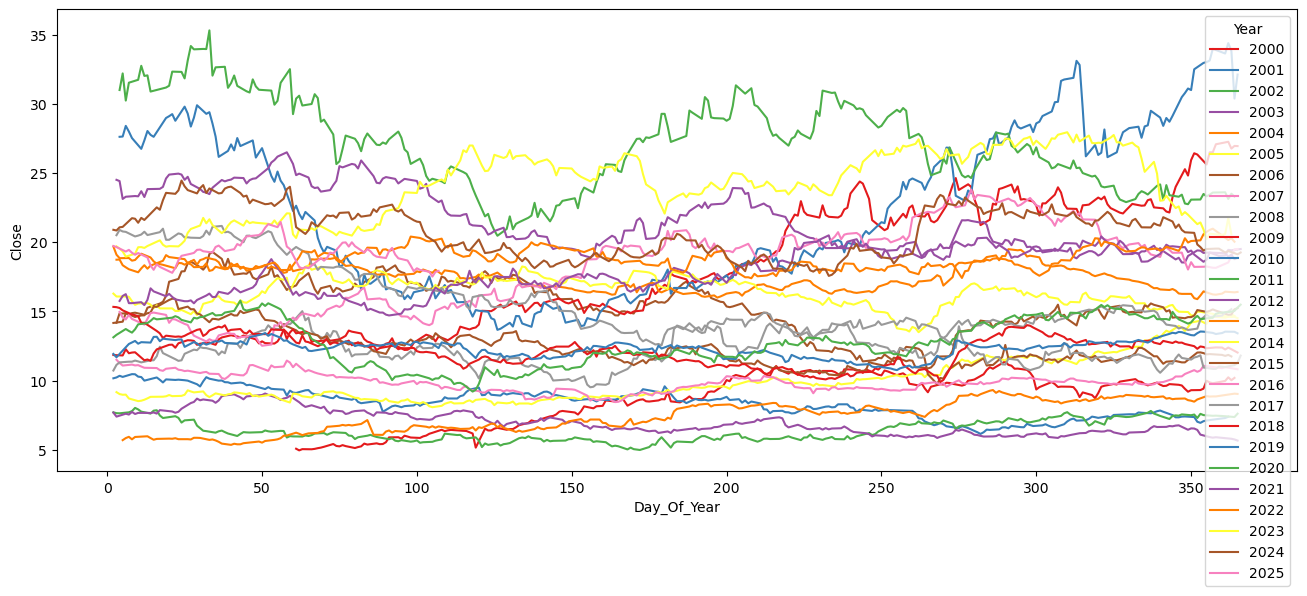

In [34]:
plt.figure(figsize = (16,6))
plt.title("Sugar Nearest to Expiration Future Close Price")
for year in df['Year'].unique():  # Loop through each unique year
    yearly_data = df[df['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = df, hue ='Year', palette='Set1')
plt.show()


count    6302.000000
mean        0.000200
std         0.020929
min        -0.180382
25%        -0.011427
50%         0.000000
75%         0.011909
max         0.235470
Name: Log_Return, dtype: float64


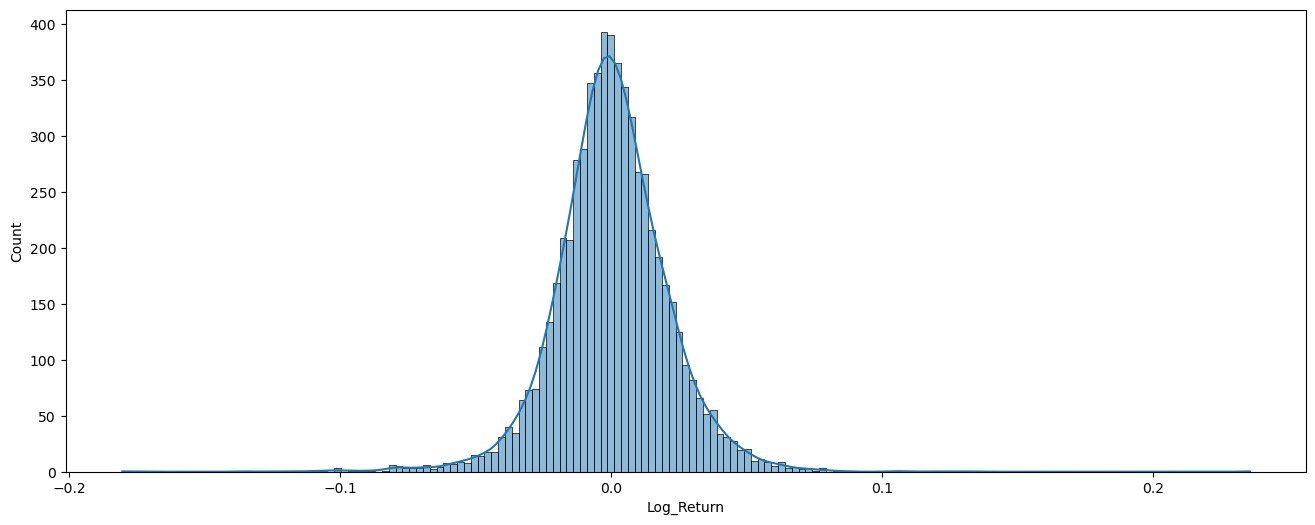

In [35]:
plt.figure(figsize = (16,6))
sns.histplot(df['Log_Return'], kde = True)
print(df['Log_Return'].describe())

The log Return is $R_t = \ln(P_t/P_{t-1}) = \ln(P_t)-\ln(P_{t-1})$. We also have the 7-day log return $\ln(P_t/P_{t-7}) = \ln(P_t/P_{t-1}) + \ln(P_{t-1}/P_{t-2})+ ... + \ln(P_{t-6}/P_{t-7})$.

If we assume that prices behave like geometric Brownian motion (GBM), it means that the increments $\ln(P_t)-\ln(P_{t-1})$ are normally distributed. This is because GBM assumes that the price $P_t$ evolves according to a stochastic differential equation where the logarithm of the price follows a Brownian motion with drift. But remember, for Brownian motion with drift, the differences have a normal distribution depending on the difference in the time increments. For a time step of 1, it's $N(\mu-\sigma^2/2,\sigma^2)$ where $\mu$ and $\sigma$ are the drift and volatility.

Suppose we have a stochastic process $X_t$ that satisfies $dX_t = \mu_t dt + \sigma_t dW_t$ where $W_t$ is the standard Brownian motion (Wiener process). Let $f(t,X_t)$ be a twice-differentiable function. Itô's lemma tells us how to compute the differential $df$.
$df(t,X_t) = \dfrac{\partial f}{\partial t} dt + \dfrac{\partial f}{\partial x} dX_t + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} (dX_t)^2$.

Essentially, it's like the usual chain rule but we have an extra term to account for the noisiness. It looks kind of weird because in usual calculus, $dx \wedge dx = 0$ but here, because of stochasticity, $(dX_t)\cdot (dX_t) =\mu^2_t dt \wedge dt + \mu_t(dt \wedge dW_t + dW_t \wedge dt) + \sigma^2_t dW_t \neq 0$. As usual, $dt \wedge dt = 0$ and in fact, so is $dt \wedge dW_t$. On the other hand, the property of the Wiener process is that $(dW_t)^2 = dt$ (recall $W_{t_2}-W_{t_1} \sim N(0,t_2-t_1)$).

So $df(t,X_t) = \dfrac{\partial f}{\partial t} dt + \dfrac{\partial f}{\partial x} (\mu_t dt + \sigma_t dW_t) + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} \sigma^2_t dt = \left(\dfrac{\partial f}{\partial t} + \mu_t \dfrac{\partial f}{\partial x} + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} \sigma^2_t \right) dt + \sigma_t \dfrac{\partial f}{\partial x} dW_t$.

If we then assume $P_t$ evolves like GBM, then $dP_t = \mu P_t dt + \sigma P_t dW_t$. We're interested in the process $Y_t = \ln(P_t)$. So $f(P_t)=\ln(P_t)$ and $\partial_P f = 1/P_t$ and $\partial^2_P f = -1/P^2_t$.

Then Itô's lemma says $dY_t = \dfrac{1}{P_t} dP_t - \dfrac{1}{2}\dfrac{1}{P^2_t} (dP_t)^2$. Subbing in $(dP_t)^2 = \sigma^2 P^2_t dt$ and $dP_t = \mu P_t dt + \sigma P_t dW_t$, we get $dY_t = (\mu - \frac{1}{2}\sigma^2)dt + \sigma dW_t$. This last equation shows that $Y_t = \ln(P_T)$ follows an arithmetic Brownian motion with drift $\mu - \frac{1}{2}\sigma^2$ and volatility $\sigma$.

There is also an interesting phenomenon that seems mathematical about geometric Brownian motion. Consider the 7-day log return. We see some spikes in the partial autocorrelation at $x$ lags where $x \equiv 1 \pmod{7}$. This is curious because there is no overlapping window. For example, when $x=8$, there is no overlapping window.

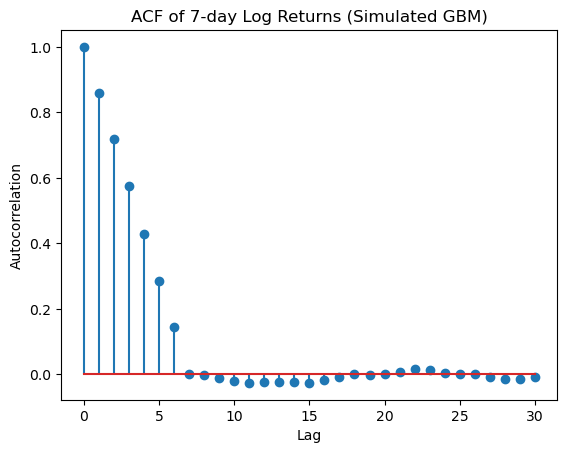

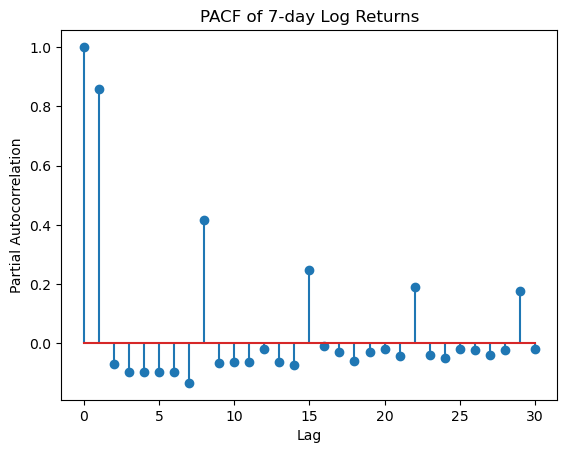

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf,pacf

# Simulation parameters
N = 3000  # number of days
mu = 0.05  # annual drift
sigma = 0.2  # annual volatility
dt = 1/252  # daily timestep

# Simulate geometric Brownian motion (log prices)
np.random.seed(0)
dW = np.random.normal(scale=np.sqrt(dt), size=N) * sigma
X = np.zeros(N)
for t in range(1, N):
    X[t] = X[t-1] + (mu - 0.5 * sigma**2) * dt + dW[t]

# Compute overlapping 7-day log returns
weekly_returns = X[7:] - X[:-7]

# Compute ACF and PACF
lags = 30
acf_vals = acf(weekly_returns, nlags=lags)
pacf_vals = pacf(weekly_returns, nlags=lags, method='ywmle')

# Plots
plt.figure()
plt.stem(range(lags+1), acf_vals)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of 7-day Log Returns (Simulated GBM)')
plt.show()


plt.figure()
markerline, stemlines, baseline = plt.stem(range(lags+1), pacf_vals)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF of 7-day Log Returns')
plt.show()


It seems this phenomenon is well-known. Let's first recall that if we have $X_t$ and $X_{t-k}$, the PACF of the two can be thought of in the following way. These live in a Hilbert space and we can project $X_t,X_{t-k}$ to the span of $X_{t-1},...,X_{t-k+1}$; this is the span of the intervening random variables. Denote the projections as $P(X_t),P(X_{t-k+1})$. Then the partial autocorrelation is the usual correlation after we subtract off the projections: $\text{Corr}(X_t - P(X_t),X_{t-k}-P(X_{t-k}))$. But there's an equivalent way to view this using $AR(k)$: $X_t = \phi_1 X_{t-1} + ... + \phi_k X_{t-k} + \epsilon_t$. The partial autocorrelation for $k$ lags is exactly $\phi_k$.

**Claims:**
* If we have an $AR(p)$ of the form $X_t - \sum^p_{i=1} \phi_i X_{t-i} = \epsilon_t$ and the AR-polynomial $\Phi(z) = 1-\sum^p_{i=0}\phi_i z^i$ has all its roots outside the closed unit disk, then we can invert: $X_t = \dfrac{1}{\Phi(L)}\epsilon_t = \sum^\infty_{j=0}\psi_j \epsilon_{t-j}$ which is an $MA(\infty)$ representation equivalent to the $AR(p)$ representation.

* Similarly, if we have $MA(q)$ of the form $X_t = \epsilon_t + \sum^q_{i=1}\theta_i \epsilon_{t-i}$ with polynomial $\Theta(z) = 1+ \sum^q_{i=1}\theta_i z^i$ which has roots outside of the closed unit disk, then we can solve for $\epsilon_t = \dfrac{1}{\Theta(L)}X_t = \sum^\infty_{k=0}\pi_k X_{t-k}$ which is an $AR(\infty)$ representation equivalent to the $MA(q)$ representation.

Now, how can we get our 7-day log return into an $AR$ form? The overlapping 7-day returns follows a moving average process $MA(6)$: $R_t = \sum^6_{i=0} \epsilon_{t-i}$ where the $\epsilon$'s are the daily log-increments (iid). But also, $MA(6)$ has an $AR(\infty)$ representation (this doesn't always exist). The characteristic polynomial of $MA(6)$ is $1+z+z^2+...+z^6 = \dfrac{1-z^7}{1-z}$ whose roots are 7th roots of 1. So we won't have a convergent power series since the roots are not outside of the closed unit disk. But we can still formally write down an inverse: $\dfrac{1-z}{1-z^7} = (1-z)\sum^\infty_{k=0}z^{7k} = \sum^\infty_{k=0}(z^{7k}-z^{7k+1})$.

Rewrite this sum as $\sum^\infty_{k=0}\phi_k z^k$. We see that $\phi_k = +1$ when $k \equiv 0 \pmod{7}$, $\phi_k = -1$ when $k \equiv 1 \pmod{7}$, and is 0 otherwise. These $\phi_k$ should be the partial-autocorrelations (up to a sign) at lag $k$ if we had infinitely many samples. Thus, the coefficients not decaying is another reason why the Taylor series doesn't converge. But because of finite sampling, the coefficients will, in practice, decay towards 0 because we have fewer effective observations.

To recap: if we measure ACF, we find $\text{Corr}(R_t, R_{t-8})=0$. But PACF is looking to explain an association between the two after we "factor" out the intervening returns. Holding those as if they're constant, it looks like PACF really does measure something nonzero.

### There's basically no seasonality

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_98951/112450169.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, power)


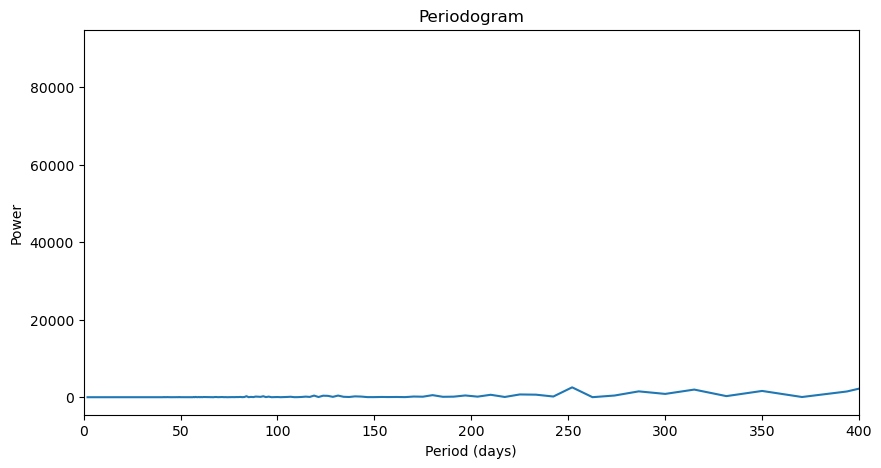

In [37]:
from scipy.signal import periodogram

frequencies, power = periodogram(df['Close'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xlim(0, 400)  # Limit x-axis to reasonable periods
plt.show()

# Adding Rolling 7 Day Average of Log Returns and Shifted Column

In [38]:
# Compute the average of the next 7 days' Log_Return values.
df['avg7Log_Return'] = [float(df['Log_Return'].iloc[i+1:i+8].mean()) if i+7 < len(df) else np.nan for i in range(len(df))]

In [39]:
df['avg7Log_Return'].head(10)

Date
2000-03-01    0.003884
2000-03-02    0.012670
2000-03-03    0.006363
2000-03-06    0.005832
2000-03-07    0.007412
2000-03-08    0.004125
2000-03-09   -0.000833
2000-03-10   -0.000548
2000-03-13   -0.004553
2000-03-14    0.004527
Name: avg7Log_Return, dtype: float64

In [40]:
df['shift_Log_Return'] = df['Log_Return'].shift(-1)

In [41]:
df[['Log_Return','shift_Log_Return']]

,Log_Return,shift_Log_Return
Date,,
2000-03-01,NaN,-0.023905
2000-03-02,-0.023905,0.017983
2000-03-03,0.017983,-0.001982
2000-03-06,-0.001982,0.005935
2000-03-07,0.005935,0.009814
...,...,...
2025-04-11,-0.006645,-0.007248
2025-04-14,-0.007248,-0.019780
2025-04-15,-0.019780,0.019220


In [42]:
df=df.dropna(subset=['shift_Log_Return'])
len(df)

6302

# We do some basic modeling on historic data (without weather data); begin with ARIMA for log Returns

In [43]:
split_index = int(len(df)*0.9) # try giving it 90% of data to train on
df_train = df[:split_index]['Log_Return']
df_test = df[split_index:]['Log_Return']

As a reminder for ARIMA

* $p$ (autoregressive order):
This is the number of lagged observations included in the model. Essentially, it tells the model how many past values of the series to use as predictors.

* $q$ (moving average order):
This represents the number of lagged forecast errors (residuals) to include. It helps model the error term as a linear combination of past error terms.

* $d$ is for differencing which is related to stationarity

For SARIMA, we also have seasonal order

* $P$: Number of seasonal autoregressive terms.

* $D$: Number of seasonal differences needed to remove seasonal trends.

* $Q$: Number of seasonal moving average terms.

* $s$: The length of the seasonal cycle (e.g., 12 for monthly data with annual seasonality, 7 for daily data with weekly seasonality).

In [44]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
# should do a grid search eventually
#model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 0, 0, 0))  # (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the SARIMA model
print(model_fit.summary())

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

                                      SARIMAX Results                                       
Dep. Variable:                           Log_Return   No. Observations:                 5671
Model:             SARIMAX(30, 1, 1)x(0, 1, [], 12)   Log Likelihood               12832.262
Date:                              Sat, 19 Apr 2025   AIC                         -25600.523
Time:                                      11:48:11   BIC                         -25388.017
Sample:                                           0   HQIC                        -25526.507
                                             - 5671                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2021      0.038     -5.315      0.000      -0.277      -0.128
ar.L2         -0.19

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


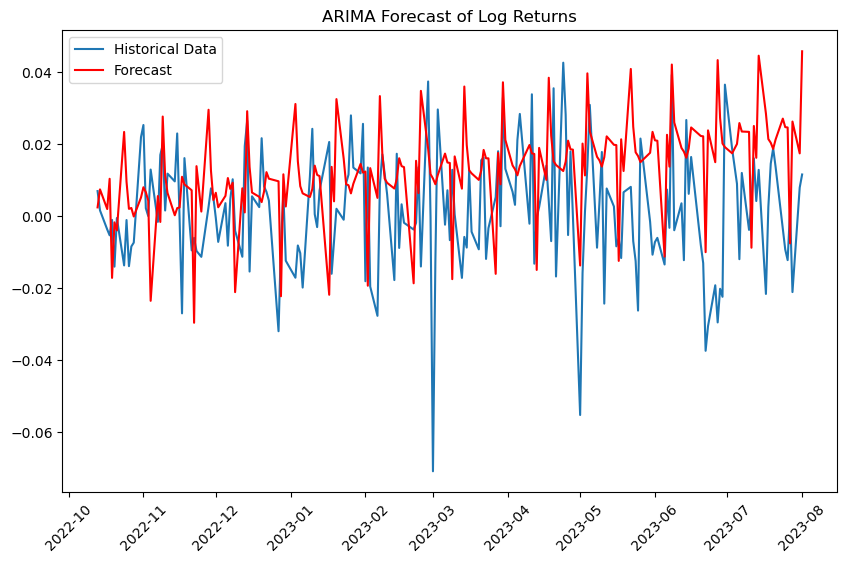

In [45]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)

forecast_steps = 200 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Log Returns')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The SARIMA model is slowly moving upwards; if we plot the full `df_test`, we'll see roughly linear growth plus noise.

In [ ]:
days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviation of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print((forecast[:day].values*df_test[:day].values>0).sum()/len(df_test[:day])) # directional accuracy
    print()

Days = 5
Standard deviation of test data: 0.0048389238342177255
Root MSE: 0.010876174682452439
R^2 score: -5.314875443803378
0.6

Days = 10
Standard deviation of test data: 0.007242340272893313
Root MSE: 0.015789428354309833
R^2 score: -4.281198033607892
0.5

Days = 15
Standard deviation of test data: 0.011697045342264246
Root MSE: 0.01474177405434027
R^2 score: -0.7018072818532952
0.6

Days = 20
Standard deviation of test data: 0.011934574555493167
Root MSE: 0.015913173765732803
R^2 score: -0.8714409197574122
0.5

Days = 25
Standard deviation of test data: 0.011668523160271567
Root MSE: 0.01512095085663753
R^2 score: -0.7492633043945978
0.56

Days = 30
Standard deviation of test data: 0.012695948585798367
Root MSE: 0.016924647108038354
R^2 score: -0.8383668960346209
0.5333333333333333



# AdaBoost

In [ ]:
df = df.dropna() # drop NaN values

features = ['Open', 'High', 'Low', 'Close', 'Volume','DTE',
       '7D_Volatility', '14D_ATR', '14D_RSI',
       '7D_MA', '7D_EMA']

target = ['shift_Log_Return']

X = df[features]
y = df[target].to_numpy().ravel() # use ravel() to get 1D array; AdaBoost didn't like the column vector

split_index = int(len(X)*0.8) # try giving it 80% of data (chronologically) to train on
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Using a custom base estimator, here a DecisionTreeRegressor with max_depth=4
base_estimator = DecisionTreeRegressor(max_depth=5)
reg = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=500, # 500 seems to be about where we start to get diminishing return; any more and we start to overfit
    learning_rate=0.1,
    loss='linear',
    random_state=42
)

reg.fit(X_train, y_train)

# Evaluate the classifier
score = reg.score(X_test, y_test)
print("R^2 score:", score)

R^2 score: -0.013808430126960092


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score

features = ['Open', 'High', 'Low', 'Close', 'Volume','DTE',
       '7D_Volatility', '14D_ATR', '14D_RSI',
       '7D_MA', '7D_EMA']
target = ['shift_Log_Return']

X = df[features]
y = df[target].to_numpy().ravel() # use ravel() to get 1D array; AdaBoost didn't like the column vector

split_index = int(len(X)*0.8) # try giving it 80% of data (chronologically) to train on
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [ ]:
# Create an XGBoost regressor with some sample hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
preds = model.predict(X_test)

# Evaluate the performance
MSE = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("R^2 Score:", r2)

print("Mean Squared Error:", MSE)


R^2 Score: 0.0006165052872925125
Mean Squared Error: 0.0003139752374311521


TimeSeriesSplit sequentially splits the data. When `n_splits = n`, the data is split into `n+1` equal sections and at the first fold, the testing is done on the first `1/(n+1)` of the data and tested on the next `1/(n+1)`. For the second fold, it's trained on the first `2/(n+1)` and tested on the third `1/(n+1)`. And so on until it trains on the first `n/(n+1)` and tested on the last `1/(n+1)`.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Suppose X is your features array and y is your target, ordered in time
features = ['Open', 'High', 'Low', 'Close', 'Volume','DTE',
       '7D_Volatility', '14D_ATR', '14D_RSI',
       '7D_MA', '7D_EMA']

target = ['shift_Log_Return']

X = df[features]
y = df[target].to_numpy().ravel()


In [ ]:
xgboost_results = np.zeros((5,2))
linear_results = np.zeros((5,2))
i=0
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45
    )

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    preds = model.predict(X_test)

    # Evaluate the performance
    xgboost_results[i,0] = mean_squared_error(y_test, preds)
    xgboost_results[i,1] = r2_score(y_test, preds)


    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict on the test set
    lr_preds = lr.predict(X_test)

    linear_results[i,0] = mean_squared_error(y_test, lr_preds)
    linear_results[i,1] = r2_score(y_test, lr_preds)

    i+=1

print(xgboost_results)
print()
print(linear_results)

[[ 6.33585134e-04 -4.81877593e-01]
 [ 7.18493408e-04 -3.77730483e-02]
 [ 3.06030312e-04  4.01713370e-03]
 [ 3.23319560e-04  2.69437139e-02]
 [ 2.95312337e-04 -4.95358010e-03]]

[[ 5.94386380e-04 -3.90196535e-01]
 [ 7.09664924e-04 -2.50214179e-02]
 [ 3.06767633e-04  1.61750720e-03]
 [ 3.30517850e-04  5.27987885e-03]
 [ 2.94018674e-04 -5.51219587e-04]]


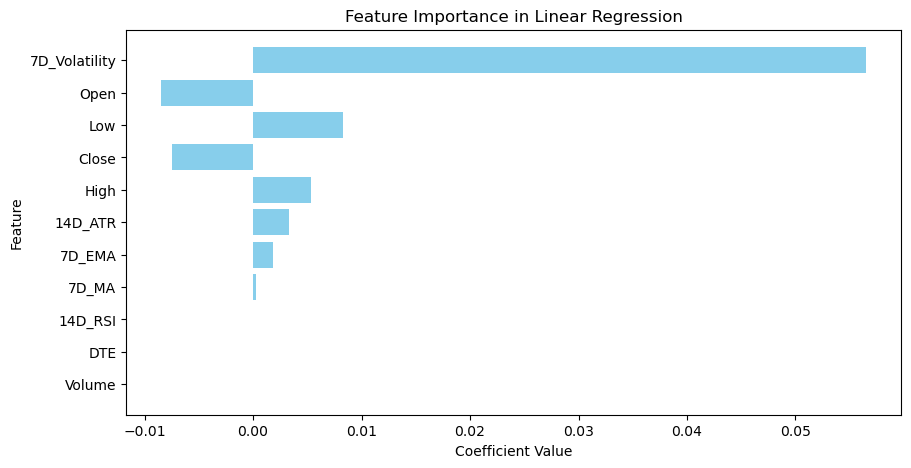

In [ ]:
coefficients = lr.coef_
coefficients_df = pd.DataFrame({"Feature": features, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Now for average 7 day log Returns prediction

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume','DTE',
       '7D_Volatility', '14D_ATR', '14D_RSI',
       '7D_MA', '7D_EMA']

target = ['avg7Log_Return']

X = df[features]
y = df[target].to_numpy().ravel() # use ravel() to get 1D array; AdaBoost didn't like the column vector

X = X[:-7] # we drop the last bit since we can't take averages beyond that
y = y[:-7]

In [ ]:
xgboost_results = np.zeros((5,2))
linear_results = np.zeros((5,2))

i=0
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45
    )

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    preds = model.predict(X_test)

    # Evaluate the performance
    xgboost_results[i,0] = mean_squared_error(y_test, preds)
    xgboost_results[i,1] = r2_score(y_test, preds)


    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict on the test set
    lr_preds = lr.predict(X_test)

    linear_results[i,0] = mean_squared_error(y_test, lr_preds)
    linear_results[i,1] = r2_score(y_test, lr_preds)

    i+=1

print(xgboost_results)
print()
print(linear_results)

[[ 7.31072507e-05 -1.62240527e-01]
 [ 9.62646237e-05 -6.25010187e-02]
 [ 4.42939647e-05 -6.53492881e-03]
 [ 5.14685061e-05 -3.10459479e-03]
 [ 4.52147774e-05 -8.34430932e-03]]

[[ 9.51349456e-05 -5.12431234e-01]
 [ 1.04714753e-04 -1.55767582e-01]
 [ 4.32077078e-05  1.81491446e-02]
 [ 5.07590921e-05  1.07216549e-02]
 [ 4.60869251e-05 -2.77942586e-02]]


## Compare to corn since corn syrup is widely used in the US while there are tariffs on imported sugar.

In [ ]:
corn = yf.Ticker('ZCH25.CBT')
df_corn = corn.history(period = 'max')
df_corn

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-14 00:00:00-05:00,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15 00:00:00-05:00,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16 00:00:00-05:00,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19 00:00:00-05:00,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20 00:00:00-05:00,570.00,570.00,565.50,565.50,1,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-21 00:00:00-05:00,498.00,499.50,490.00,491.25,209485,0.0,0.0
2025-02-24 00:00:00-05:00,490.00,491.00,481.50,482.50,189315,0.0,0.0
2025-02-25 00:00:00-05:00,483.25,484.50,474.25,479.75,116438,0.0,0.0


In [ ]:
# Make both indices timezone-naive (some datetime stamps are aware of the time zone)
df_sugar.index = df_sugar.index.tz_localize(None)
df_corn.index = df_corn.index.tz_localize(None)

df_merged = pd.merge(df_sugar, df_corn, left_index=True, right_index=True, how='inner')

In [ ]:
df_merged.head()

,open,high,low,close,volume,MA_10,MA_50,MA_200,Open,High,Low,Close,Volume,Dividends,Stock Splits
2022-12-14,19.660000,20.410000,19.590000,20.290001,98681,19.623,19.0520,18.83290,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15,20.280001,20.730000,19.860001,19.980000,105852,19.659,19.0926,18.83960,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16,19.879999,20.290001,19.799999,20.090000,53257,19.720,19.1252,18.84540,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19,20.100000,20.430000,20.030001,20.139999,52544,19.779,19.1544,18.84935,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20,20.150000,20.700001,20.139999,20.580000,74725,19.898,19.1938,18.85590,570.00,570.00,565.50,565.50,1,0.0,0.0


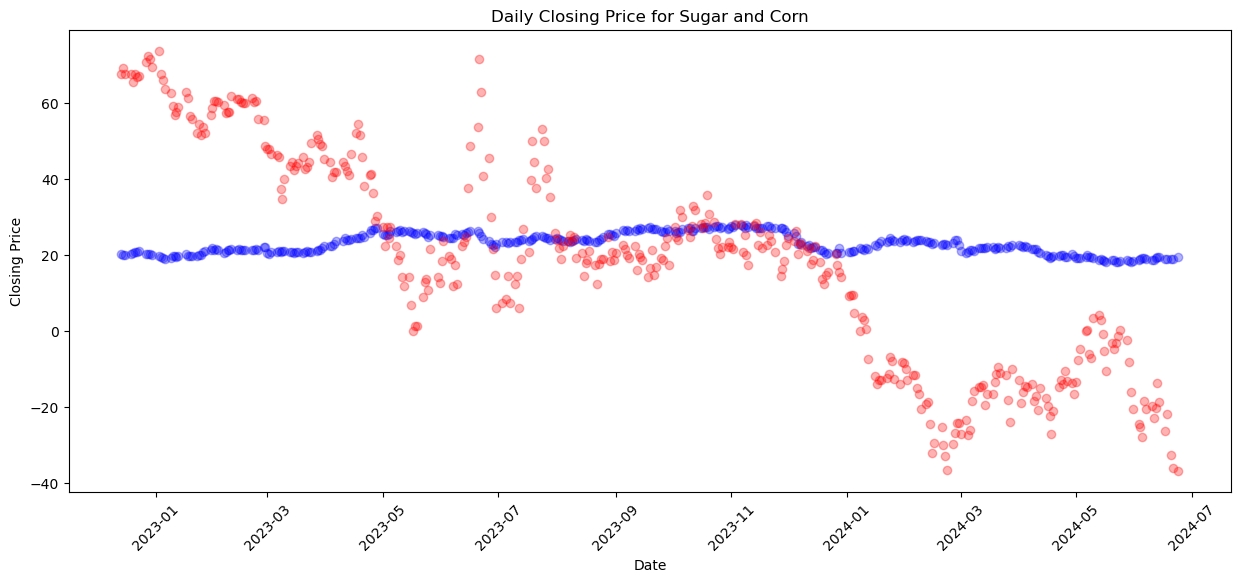

In [ ]:
# Plot daily closing price

plt.figure(figsize=(15, 6))
plt.scatter(df_merged.index, df_merged['close'], label='Sugar', color='blue',alpha=0.3) # sugar
plt.scatter(df_merged.index, df_merged['Close']-500, label='Corn', color='red',alpha=0.3) # corn but shifted down


plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Daily Closing Price for Sugar and Corn')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

We'll try standardizing each dataset.

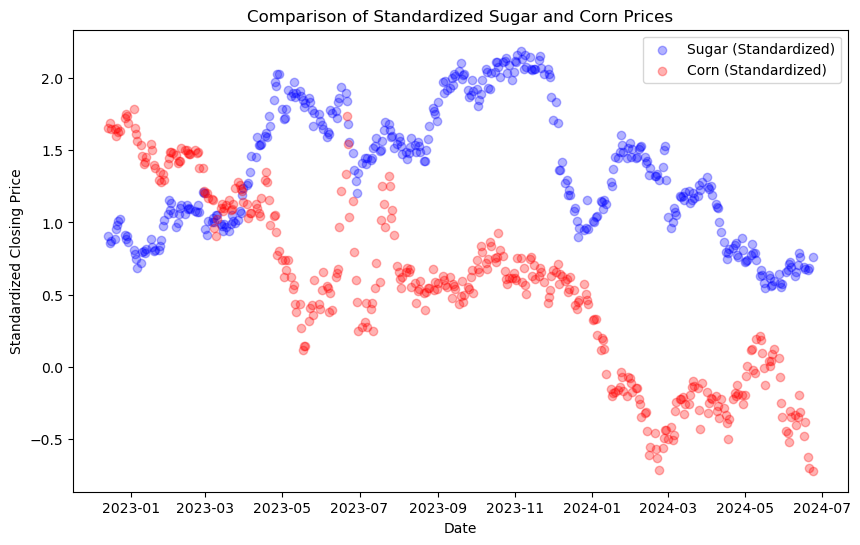

In [ ]:
# Standardize each dataset (Z-score normalization)
df_sugar_standard = (df_sugar['close'] - df_sugar['close'].mean()) / df_sugar['close'].std()
df_corn_standard = (df_corn['Close'] - df_corn['Close'].mean()) / df_corn['Close'].std()
df_merged_standard = pd.merge(df_sugar_standard, df_corn_standard, left_index=True, right_index=True, how='inner')

# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged_standard.index, df_merged_standard['close'], label='Sugar (Standardized)', color='blue',alpha=0.3)
plt.scatter(df_merged_standard.index, df_merged_standard['Close'], label='Corn (Standardized)', color='red',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Comparison of Standardized Sugar and Corn Prices')
plt.legend()
plt.show()


In [ ]:
print('Covariance Matrix: ', np.cov(df_merged['close'],df_merged['Close']))
print()
print('Correlation:', df_merged['close'].corr(df_merged['Close']))

Covariance Matrix:  [[  7.24513379   8.8328895 ]
 [  8.8328895  750.89049939]]

Correlation: 0.11975434730155342


In [ ]:
# let's try to get some kind of rolling covariance/correlation
rolling_cov = df_merged['close'].rolling(window=5).cov(df_merged['Close'])
rolling_cov

2022-12-14         NaN
2022-12-15         NaN
2022-12-16         NaN
2022-12-19         NaN
2022-12-20   -0.280625
                ...   
2024-06-17    1.303501
2024-06-18    1.154501
2024-06-20    1.992753
2024-06-21    0.999253
2024-06-24   -0.749499
Length: 382, dtype: float64

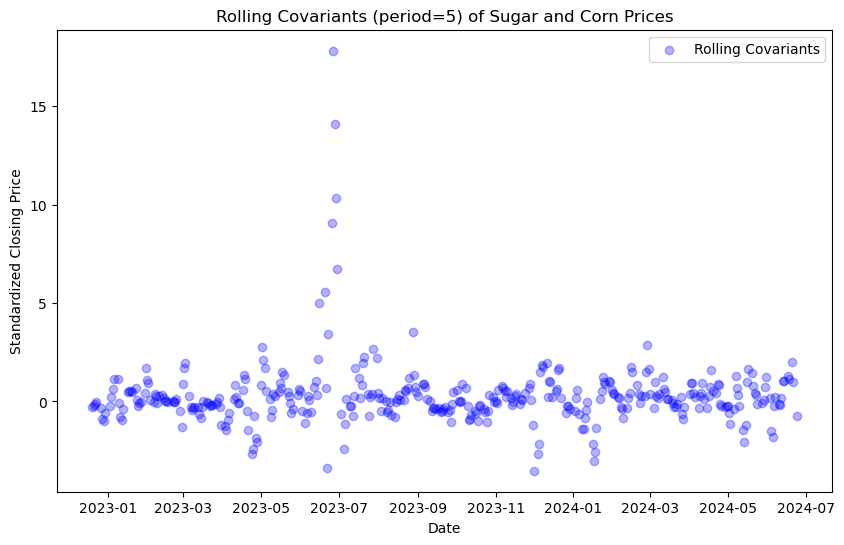

In [ ]:
# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged.index, rolling_cov, label='Rolling Covariants', color='blue',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Rolling Covariants (period=5) of Sugar and Corn Prices')
plt.legend()
plt.show()
